In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler


class StandardScalerDf:
    
    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self, df):
        self.scaler.fit(df)
        
    def transform(self, df):
        df_ = self.scaler.transform(df)
        df_ = pd.DataFrame(df_, index=df.index, columns=df.columns)
        return df_


class LogitScalerStandardScaler:
    
    def __init__(self):
        self.scaler = StandardScaler()
        
    def fit(self, df):
        df_ = np.log(df/(100 - df))
        self.scaler.fit(df_)
    
    def transform(self, df):
        df_ = np.log(df/(100 - df))
        df__ = self.scaler.transform(df_)
        df__ = pd.DataFrame(df__, index=df.index, columns=df.columns)
        return df__
    
    def inverse_transform(self, df__):
        df_ = self.scaler.inverse_transform(df__)
        df_ = pd.DataFrame(df_, index=df__.index, columns=df__.columns)
        df = 100 * np.exp(df_)/(1 + np.exp(df_))
        return df


class ZeroLogitRidgeCV:
    
    def __init__(self, X, y, groups):
        self.X = X
        
        self.y = y
        
        self.groups = groups
        
        self.X_pp = StandardScalerDf()
        self.X_pp.fit(self.X)
        self.X_ = self.X_pp.transform(self.X)
        
        self.y_pp = LogitScalerStandardScaler()
        self.y_pp.fit(self.y)
        self.y_ = self.y_pp.transform(self.y)
        
        self.model_ = None
        
        self.y_pred_ = None
        
        self.y_pred = None
        
    def fit(self):
        alpha = 100.0
        
        for i in range(1, -3, -1):
            model = Ridge()
            params = {
                "alpha":[alpha + j*10**(i) for j in range(-9, 10)]
            }
            gscv = GridSearchCV(
                model,
                params,
                cv=LeaveOneGroupOut(),
                scoring="neg_mean_squared_error",
                n_jobs=1,
                refit=True
            )
            gscv.fit(self.X_, self.y_, groups=self.groups)
            alpha = gscv.best_params_["alpha"]
            
        self.model_ = gscv.best_estimator_
    
    def predict(self):
        y_pred_ = self.model_.predict(self.X_)
        self.y_pred_ = pd.DataFrame(y_pred_, index=self.y_.index, columns=self.y_.columns)
        self.y_pred = self.y_pp.inverse_transform(self.y_pred_)
        

In [2]:
X_path = "./X.csv"
X = pd.read_csv(X_path, index_col=["backbone", "pyridone"])
X = X.sub(X["0"], axis=0)
X = X.drop("0", axis=1)
display(X)

y_path = "./y.csv"
y = pd.read_csv(y_path, index_col=["backbone", "pyridone"])
display(y)

models = {}
columns = X.columns

for n_features in range(len(X.columns), 4, -1):
    print(f"--- n_features={n_features} ---")
    groups = X.index.get_level_values("pyridone")
    model = ZeroLogitRidgeCV(X[columns], y, groups)
    model.fit()
    print(model.model_.get_params()["alpha"])
    model.predict()
    models[n_features] = model
    
    coef_df = pd.DataFrame(model.model_.coef_, index=["coef"], columns=columns)
    columns_min = coef_df.abs().idxmin(axis=1)
    columns = columns.drop(columns_min)
    

2         3         4         6         7         9  \
backbone pyridone                                                               
0        0        -0.008695 -0.057056 -0.008886 -0.026198 -0.041120  0.032579   
         1        -0.008695 -0.052599 -0.008886 -0.021780 -0.036864  0.032579   
         2        -0.008695 -0.054448 -0.008886 -0.023546 -0.038881  0.032579   
         3        -0.008695 -0.052436 -0.008886 -0.022054 -0.037311  0.032579   
         4        -0.008695 -0.053723 -0.008886 -0.025236 -0.039595  0.032579   
...                     ...       ...       ...       ...       ...       ...   
20       8        -0.008767 -0.046001 -0.008959 -0.024819 -0.038401  0.032447   
         9        -0.008767 -0.057810 -0.008959 -0.029390 -0.042452  0.032447   
         10       -0.008767 -0.046827 -0.008959 -0.026338 -0.039197  0.032447   
         11       -0.008767 -0.047412 -0.008959 -0.027697 -0.039272  0.032447   
         12       -0.008767 -0.056018 -0.008959 -0.026983 -0.040581  0.032447   

                         12        14        16        18  ...       507  \
backbone pyridone                                          ...             
0        0        -0.050338 -0.056655 -0.064589 -0.059825  ... -0.094124   
         1        -0.050736 -0.053830 -0.064255 -0.062201  ... -0.091687   
         2        -0.052990 -0.055201 -0.064532 -0.060393  ... -0.093373   
         3        -0.054012 -0.054275 -0.065711 -0.061291  ... -0.093179   
         4        -0.053024 -0.055508 -0.065862 -0.060430  ... -0.094225   
...                     ...       ...       ...       ...  ...       ...   
20       8        -0.047765 -0.056455 -0.062096 -0.060130  ... -0.091707   
         9        -0.053905 -0.055819 -0.067570 -0.058327  ... -0.094560   
         10       -0.049379 -0.056267 -0.064423 -0.059175  ... -0.091984   
         11       -0.053060 -0.056908 -0.067281 -0.056894  ... -0.092795   
         12       -0.051470 -0.054585 -0.066968 -0.060803  ... -0.092563   

                        519       538       540       543       575       597  \
backbone pyridone                                                               
0        0        -0.099624 -0.089446 -0.090086 -0.084177 -0.093292 -0.091567   
         1        -0.096809 -0.087070 -0.088095 -0.082335 -0.090797 -0.089023   
         2        -0.099589 -0.087857 -0.089579 -0.082563 -0.092372 -0.089866   
         3        -0.097998 -0.087177 -0.089471 -0.084803 -0.094709 -0.088976   
         4        -0.099139 -0.088837 -0.089840 -0.083402 -0.092848 -0.090779   
...                     ...       ...       ...       ...       ...       ...   
20       8        -0.093021 -0.084357 -0.088355 -0.081076 -0.090303 -0.081064   
         9        -0.102201 -0.088485 -0.091040 -0.083632 -0.092650 -0.085170   
         10       -0.094866 -0.084769 -0.089273 -0.082601 -0.090553 -0.081496   
         11       -0.095046 -0.083823 -0.090071 -0.081768 -0.091257 -0.081348   
         12       -0.100542 -0.087970 -0.088658 -0.082708 -0.090361 -0.084223   

                        602       605       642  
backbone pyridone                                
0        0        -0.079205 -0.087926 -0.089446  
         1        -0.075984 -0.085548 -0.087070  
         2        -0.078479 -0.086393 -0.087857  
         3        -0.078163 -0.085580 -0.087177  
         4        -0.078987 -0.087082 -0.088837  
...                     ...       ...       ...  
20       8        -0.073291 -0.083268 -0.083104  
         9        -0.079348 -0.087811 -0.088484  
         10       -0.074080 -0.083599 -0.083851  
         11       -0.074368 -0.083447 -0.083823  
         12       -0.076616 -0.086800 -0.087970  

[104 rows x 51 columns]

beta_av
backbone pyridone           
0        0         51.388357
         1         63.841924
         2         59.085161
         3         53.059721
         4         53.917807
...                      ...
20       8         19.228094
         9         24.595903
         10        21.060263
         11        19.203989
         12        23.601443

[104 rows x 1 columns]

--- n_features=51 ---
18.66
--- n_features=50 ---
17.97
--- n_features=49 ---
17.28
--- n_features=48 ---
16.26
--- n_features=47 ---
15.08
--- n_features=46 ---
13.02
--- n_features=45 ---
11.67
--- n_features=44 ---
4.85
--- n_features=43 ---
4.84
--- n_features=42 ---
3.54
--- n_features=41 ---
3.73
--- n_features=40 ---
3.7
--- n_features=39 ---
3.88
--- n_features=38 ---
3.85
--- n_features=37 ---
3.96
--- n_features=36 ---
2.95
--- n_features=35 ---
3.1700000000000004
--- n_features=34 ---
3.22
--- n_features=33 ---
3.65
--- n_features=32 ---
5.6
--- n_features=31 ---
5.14
--- n_features=30 ---
5.25
--- n_features=29 ---
5.29
--- n_features=28 ---
5.0
--- n_features=27 ---
4.73
--- n_features=26 ---
4.680000000000001
--- n_features=25 ---
3.92
--- n_features=24 ---
3.61
--- n_features=23 ---
3.27
--- n_features=22 ---
2.96
--- n_features=21 ---
3.38
--- n_features=20 ---
3.0900000000000003
--- n_features=19 ---
2.87
--- n_features=18 ---
2.68
--- n_features=17 ---
2.35
--- n_feat

In [3]:
models_se = pd.Series(models)
print(models_se)


51    <__main__.ZeroLogitRidgeCV object at 0x15c6a0be0>
50    <__main__.ZeroLogitRidgeCV object at 0x15c6bf430>
49    <__main__.ZeroLogitRidgeCV object at 0x15e6e3640>
48    <__main__.ZeroLogitRidgeCV object at 0x15e6d4b80>
47    <__main__.ZeroLogitRidgeCV object at 0x15e6e3be0>
46    <__main__.ZeroLogitRidgeCV object at 0x15e707fd0>
45    <__main__.ZeroLogitRidgeCV object at 0x15e707100>
44    <__main__.ZeroLogitRidgeCV object at 0x15c6a0880>
43    <__main__.ZeroLogitRidgeCV object at 0x15e707130>
42    <__main__.ZeroLogitRidgeCV object at 0x15c6bf9a0>
41    <__main__.ZeroLogitRidgeCV object at 0x15e6e5670>
40    <__main__.ZeroLogitRidgeCV object at 0x15e6d4dc0>
39    <__main__.ZeroLogitRidgeCV object at 0x15c6bffa0>
38    <__main__.ZeroLogitRidgeCV object at 0x15e6fa3d0>
37    <__main__.ZeroLogitRidgeCV object at 0x15e6faa60>
36    <__main__.ZeroLogitRidgeCV object at 0x15e7484f0>
35    <__main__.ZeroLogitRidgeCV object at 0x15e745ac0>
34    <__main__.ZeroLogitRidgeCV object at 0x15e

In [4]:
import pickle


models_path = "./Ridge_RFE_zero_models_remodeled.pickle"

with open(models_path, "wb") as f:
    pickle.dump(models_se, f)
    

In [5]:
import pickle


models_path = "./Ridge_RFE_zero_models_remodeled.pickle"

with open(models_path, "rb") as f:
    models_se = pickle.load(f)
    

In [6]:
from sklearn.metrics import mean_squared_error


rmse_se = models_se.apply(lambda model: mean_squared_error(model.y, model.y_pred, squared=False))
print(rmse_se)


51    4.661881
50    4.642700
49    4.622832
48    4.592383
47    4.555226
46    4.485551
45    4.435571
44    4.092941
43    4.092264
42    3.992833
41    4.008052
40    4.005178
39    4.018486
38    4.018721
37    4.024203
36    3.939771
35    3.955787
34    3.959363
33    3.987322
32    4.118775
31    4.099881
30    4.108152
29    4.108907
28    4.091276
27    4.080621
26    4.078722
25    4.038771
24    4.020647
23    3.997533
22    3.969425
21    3.986073
20    3.980798
19    3.967596
18    3.950337
17    4.008371
16    3.954367
15    3.941399
14    3.936890
13    3.979384
12    3.900257
11    3.861018
10    3.912983
9     4.305370
8     4.836002
7     5.233835
6     5.413532
5     5.388852
dtype: float64


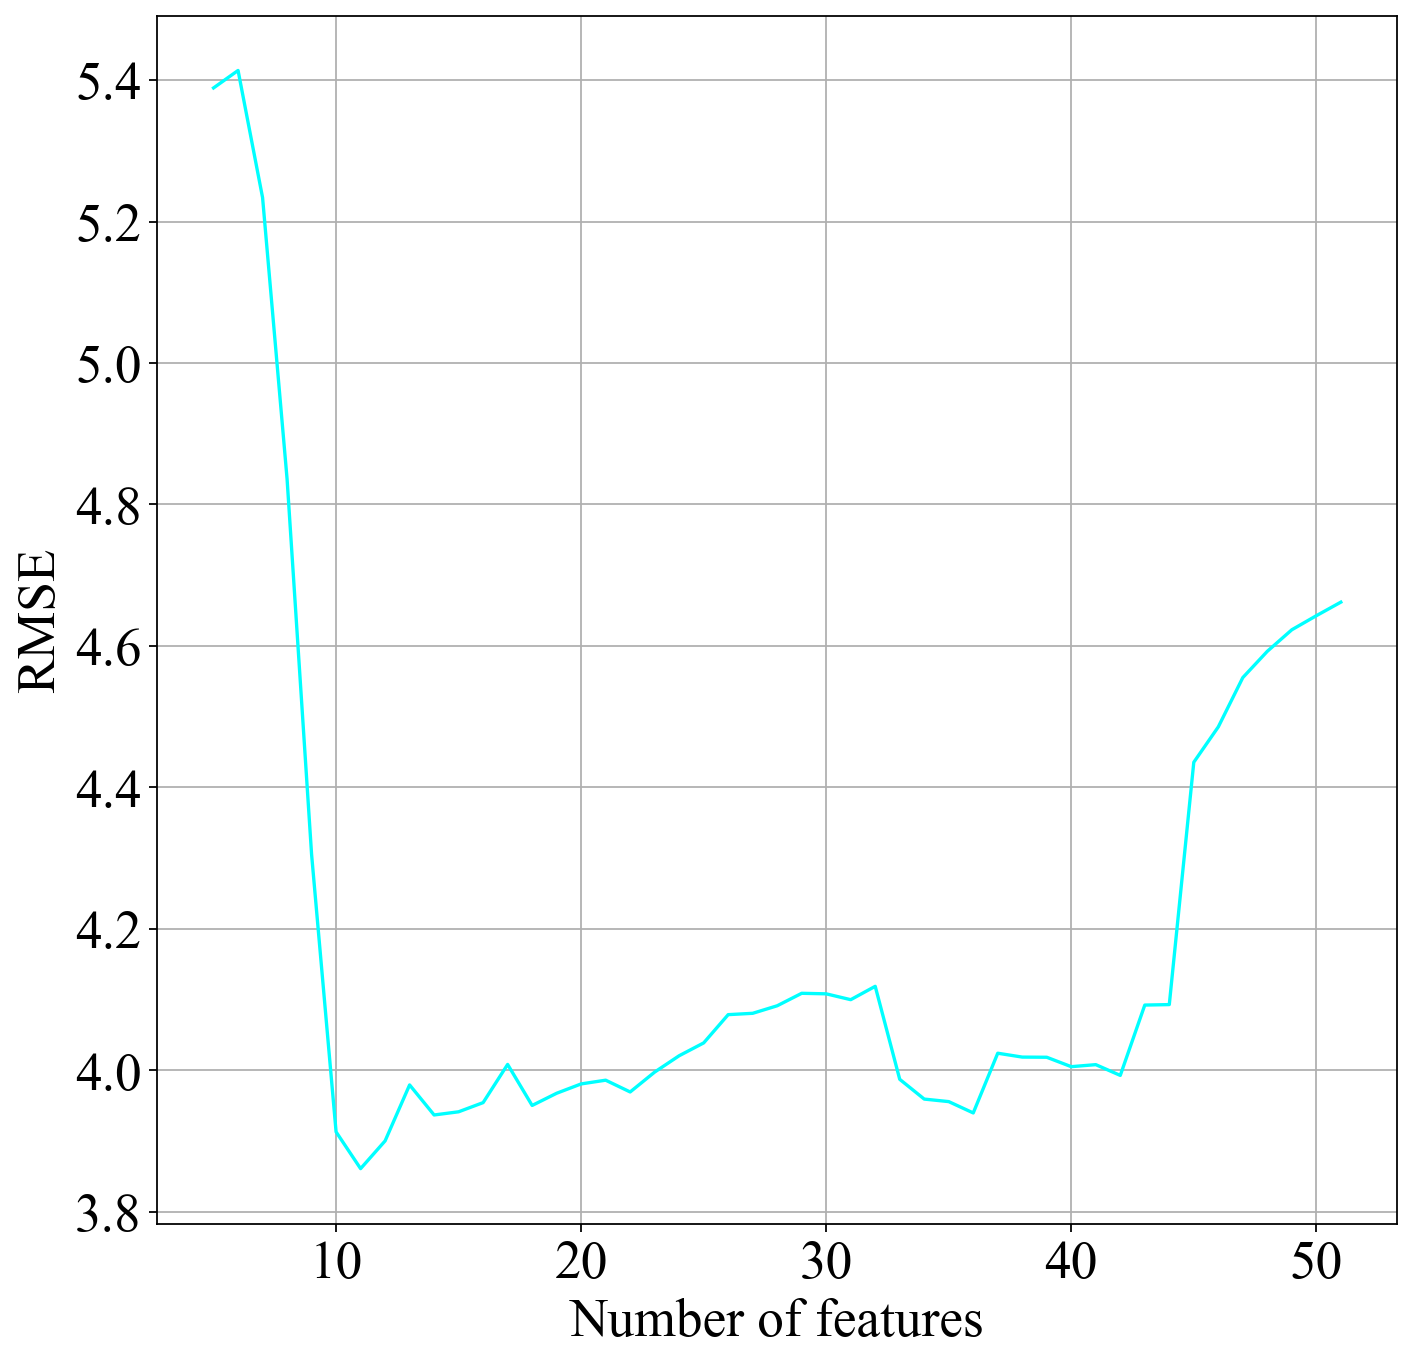

In [12]:
import matplotlib.pyplot as plt


plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Number of features")
ax.set_ylabel("RMSE")
ax.plot(rmse_se.index, rmse_se.values, color="cyan")
ax.grid()
plt.savefig("./Ridge_RFE_zero_RMSE_remodeled.png")
plt.show()


In [13]:
n_features_min = rmse_se.idxmin()
print(n_features_min)

11


In [14]:
rmse_min = rmse_se.min()
print(rmse_min)

3.861017570557887


In [22]:
column = models_se[n_features_min].X.columns
coef = models_se[n_features_min].model_.coef_.flatten()
coef_se = pd.Series(coef, index=column)
print(coef_se)


7      0.498711
91    -0.448177
232   -0.327649
234    0.355742
235    0.610951
240   -0.900349
271    0.829352
324   -0.890746
469   -0.355727
494    0.235519
543    0.502156
dtype: float64


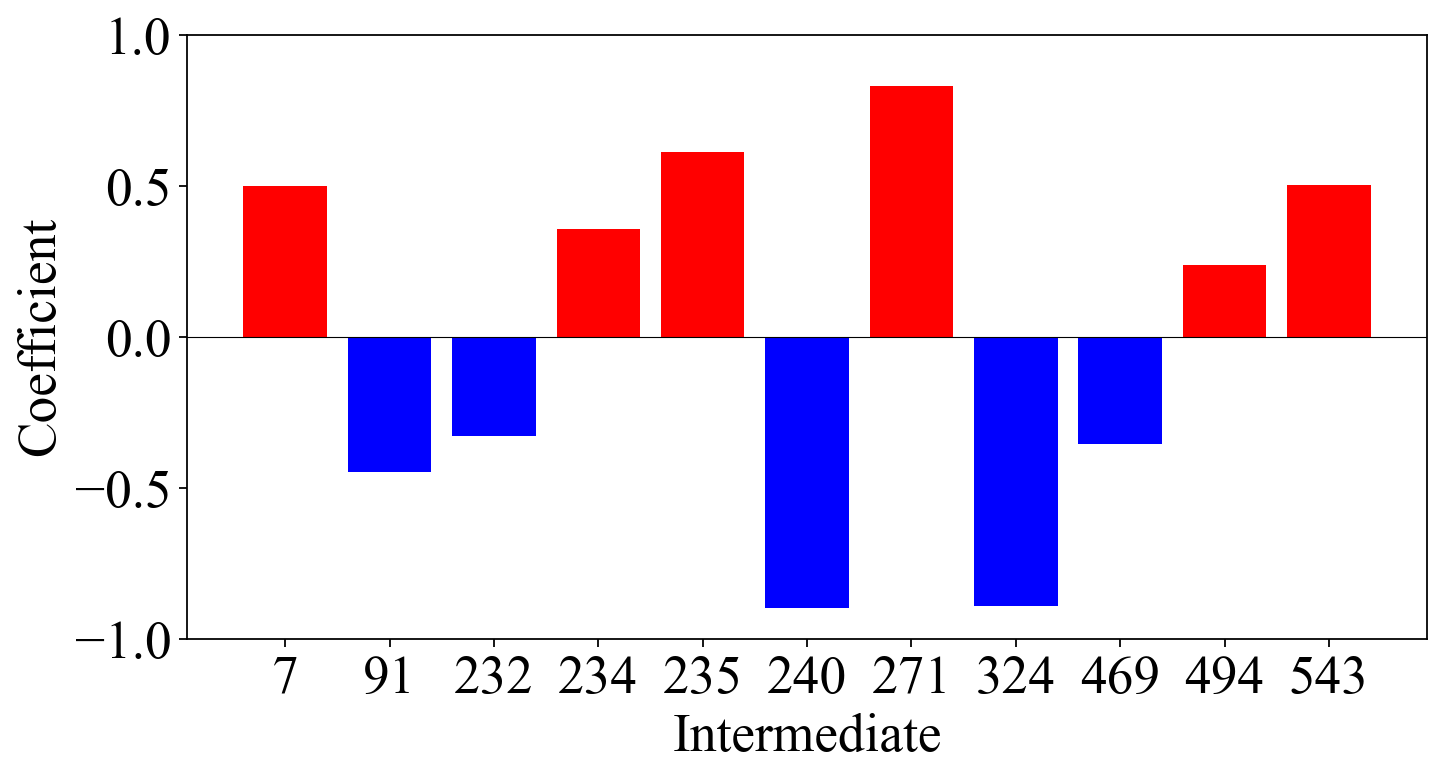

In [32]:
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel("Intermediate")
ax.set_ylabel("Coefficient")
ax.bar(coef_se.index, coef_se.values*(coef_se.values>0), color="red")
ax.bar(coef_se.index, coef_se.values*(coef_se.values<0), color="blue")
ax.axhline(y=0.0, linewidth=0.5, color="black")
ax.set_ylim(-1.0, 1.0)
plt.savefig("./Ridge_RFE_zero_coefficient_remodeled.png")
plt.show()
